![picture](https://prowly-uploads.s3.eu-west-1.amazonaws.com/uploads/4626/assets/71776/large_logo_wsb_poziom.jpg)

# WPROWADZENIE DO ALGORYTMÓW GŁĘBOKIEGO UCZENIA MASZYNOWEGO - DEEP LEARNING

## Problem klasyfikacji zdjęć przy użyciu sieci konwolucyjnch:
<ul>
    <li>Pobieranie danych i wgrywanie do środowiska roboczego.</li>
    <li>Czym jest warstwa konwolucyjna w sieci neuronowej?</li>
    <li>Przykładowy model sieci neuronowej.</li>
    <li>Wizualizacja oraz walidacja procesu uczenia się modelu. Dokładność predykcji na zbiorze testowym.</li>
    <li>Transfer learning z wykorzystaniem modelu VGG16.</li>
    <li>Wizualizacja warstw konwolucyjnych.</li>
</ul>

## *Pobieranie danych - NIE WYKONUJ

Na dzisiejszych zajęciach będziemy korzystać ze zbioru dostępnego na stronie kaggle (<a href="https://www.kaggle.com/puneet6060/intel-image-classification?select=seg_train">link</a>).
Struktura zbioru dostępna pod linkiem różni się od docelowej (fodery dla zbiorów treningowego, walidacyjnego oraz testowego oraz podfoldery dla różnie oznaczonych zdjęć).<br>
W poniższej komórce podaję Państwu kod do ściągnięcia dowolnego zbioru z Kaggle po założeniu konta na kaggle i ściągnięciu pliku konfiguracyjnego.

In [ ]:
# PEŁNA INSTRUKCJA: https://github.com/Kaggle/kaggle-api

#from google.colab import drive
#drive.mount('/content/gdrive')

#import os
#os.environ['KAGGLE_CONFIG_DIR'] = "ścieżka do pliku kaggle.json"
#!kaggle datasets download -d puneet6060/intel-image-classification # Komenda jest generowana przy użyciu 'Copy API Command' w Kaggle.
#!unzip \*.zip  && rm *.zip
# Proszę zauważyć, że colab rozumie komendy UNIX, ponieważ całość pracuje na Ubuntu.

W przypadku dzisiejszych zajęć nie ma potrzeby pobierać danych na prywatny drive przy użyciu kaggle API. Proszę:
<li>Pobrać plik Intel "Image Classification demo.zip"</li>
<li>Wypakować</li>
<li>Wgrać folder w lokalizacji "Mój Dysk/AI_datasets"/"My Drive/AI_datasets"</li>

<i><b> Uwaga: </i></b> Rozmiar analizowanego zbióru został dostosowany do możliwości obliczeniowych na zajęciach - oryginalnie jest to prawie 18 000 zdjęć. Jeżeli ktoś chciałby wytrenować model na pełnym zbiorze, proszę skorzystać z <a href="https://drive.google.com/drive/folders/14TFtUM4DM_zsGpK9fcedt3jgnTMOabH4?usp=sharing">linku</a>

## Wgrywanie do środowiska roboczego.

Łączenie z Google Drive pozwala na korzystanie z plików, które są w nim dostępne.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dropout, Dense
from tensorflow.keras.applications.vgg16 import VGG16
import pandas
from tensorflow.keras.optimizers import Adamax, Adam
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.utils.multiclass import unique_labels
import os
import json
from sklearn import metrics
from tensorflow.keras import regularizers

Proszę się upewnić, że pod ścieżką znajduje się folder "Intel Image Classification demo".

In [ ]:
%cd /content/gdrive/My Drive/AI_datasets
!ls

/content/gdrive/My Drive/AI_datasets
 2017_Financial_Data.csv      'Intel Image Classification demo'
 CarPrice_Assignment.csv       logs
 house_price_prediction.csv    Lyrics
 insurance.csv		       marketing_campaign.csv
 insurance_kz.csv	       Music_genre
'Intel Image Classification'   planesnet_split


In [ ]:
# Jest wiele sposobów na wgranie plików do Colab. Dzisiaj użyjemy obiektu ImageDataGenerator oraz metody flow_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Obiekty ImageDataGenerator decyduje o tym, jakie operacje zostaną wykonane na zdjęciach podczas wgrywania do sesji.
# link: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255, # skalowanie zdjęć
                                   shear_range = 0.2, # losowo przycina zdjęcia
                                   zoom_range = 0.2, # losowo przybliża zdjęcia
                                   validation_split = 0.2, # zdjęcia z folderu train zostaną automatycznie podzielone na część treningową i walidacyjną w proporji 0.8/0.2
                                   horizontal_flip = True) # przekręca losowe zdjęcia horyzontalnie
# Na zbiorze testowym nie są wykonywane żadne dodatkowe operacje.
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
%cd Intel\ Image\ Classification\ demo 
# ustaw odpowiednią ścieżkę

# flow_from_directory przypisuje zdjęcia z odpowiednich folderów do obiektów w batches. Wszystkie zdjęcia nie są od razu dostępne w np. train_dataset,
# gdyż jest to kolejny obiekt z wieloma funkcjami. Odpowiednie zdjęcia są ładowane w batches podczas trenowania modelu.
train_dataset = train_datagen.flow_from_directory('train', # nazwa podfolderu
                                                  target_size = (150, 150), # rozmiar zdjęcia
                                                  batch_size = 10, # wielkość batches, używając pełnego zbioru sugerowane są wyższe wartośći, np. 128
                                                  subset = 'training') # podzbiór treningowy lub walidacyjny
val_dataset = train_datagen.flow_from_directory('train',
                                                target_size = (150, 150),
                                                batch_size = 10,
                                                subset = 'validation')
test_dataset = test_datagen.flow_from_directory('test',
                                            target_size = (150, 150),
                                            batch_size = 10)

/content/gdrive/MyDrive/AI_datasets/Intel Image Classification demo
Found 120 images belonging to 3 classes.
Found 29 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


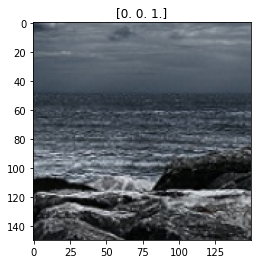

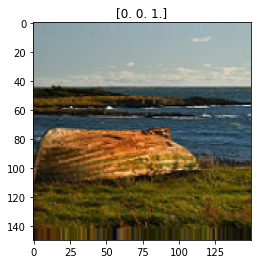

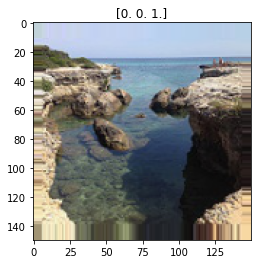

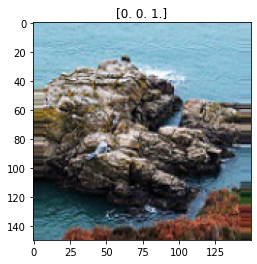

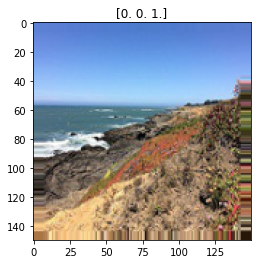

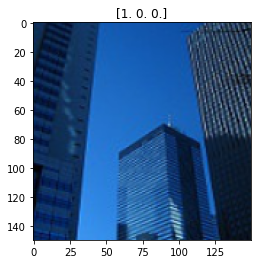

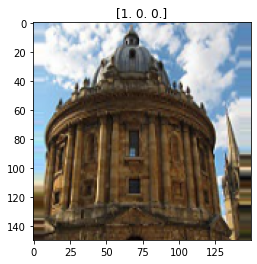

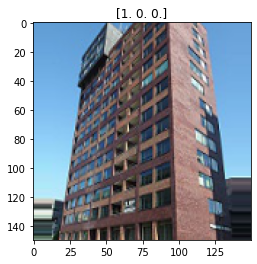

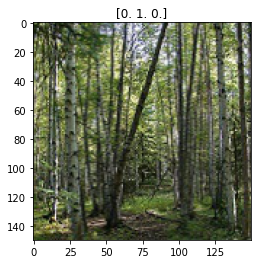

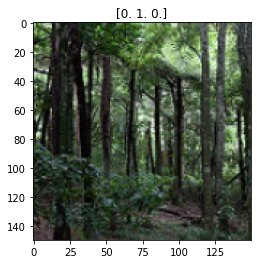

In [ ]:
# Funkcja .next() zwraca koleny batch zdjęć. Możemy jej użyć do wizualizacji zdjęć oraz odczytania ich etykiet (label).
test_dataset.shuffle=False
x,y= train_dataset.next()
for i in range(0,10):
    image = x[i]
    plt.imshow(image)
    plt.title(y[i])
    plt.show()

W naszym przypadku mamy zbiór danych z 3 etykietami. Zakodowane są one w formie zero-jedynkowej, gdzie każda kolumna odpowiada za inną etykietę. Jedno zdjęcie może być przyporządkowane do jednej etykiety, więc w tym przypadku mamy do rozwiązania problem tzw. klasyfikacji wieloklasowej/multi-class (nie mylić z klasyfikacją wieloetykietową/multi-label).

## Jak działa konwolucyjna sieć neuronowa?

Zdjęcia RGB jako dane wejściowe interpretowane są jako kostka <i>[wysokość_zdjęcia,szerokość_zdjęcia,3]</i>. W przypadku zdjęcia 224x224, mowa jest o 150 528 wartościach opisujących jedno zdjęcie. Bardzo często o nadaniu etykiety nie decyzują wszystkie te wartości, a jedynie punkty charakterystyczne fotografii (pionowe i poziome linie w budynkach, trójkąte uszy kotów, linia horyzontu na morzu itp.). Do wydobycia jego kluczowych elementów, w sieciach neuronowych używane są warstwy konwolucyjne.

### Warstwa konwolucyjna

<b> Jak działa warstwa konwolucyjna w sieci neuronowej?</b>

Dokłady opis schematu uczenia się konwolucyjnej sieci neuronowej dostępny w <a href ="https://arxiv.org/ftp/arxiv/papers/1506/1506.01195.pdf">artykule</a>.

![picture](https://drive.google.com/uc?id=1-1KV5e4LMi2IoT_WX3WCxqmLq12J9bDy)

*Wartości w jądrze filtrów mogą przyjąć wartości ujemne. Funkcja aktywacji relu mapuje wartości ujemne w wyniku na zero.

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
x = tf.constant([[ 0.,1.,0.,1.,],
                 [ 1.,0.,0.,1.,],
                 [ 1.,1.,0.,0.,],
                 [ 0.,1.,0.,1.,]])
x = tf.reshape(x, [1, 4, 4, 1])
conv_1 = tf.keras.layers.Conv2D(1, kernel_size=(2,2), strides=(1, 1), padding='valid')
conv_1(x)
conv_1.set_weights([np.array([[[[0]],[[1]]],[[[1]],[[0]]]]),np.array([0])])
np.round(conv_1(x))

array([[[[2.],
         [0.],
         [1.]],

        [[1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [0.]]]], dtype=float32)

In [ ]:
x = tf.constant([[ 0.,1.,0.,1.,],
                 [ 1.,0.,0.,1.,],
                 [ 1.,1.,0.,0.,],
                 [ 0.,1.,0.,1.,]])
x = tf.reshape(x, [1, 4, 4, 1])
conv_1 = tf.keras.layers.Conv2D(1, kernel_size=(3,3), strides=(1, 1), padding='valid')
conv_1(x)
conv_1.set_weights([np.array([[[[0]],[[1]],[[1]]],[[[1]],[[0]],[[0]]],[[[1]],[[0]],[[0]]]]),np.array([0])])
np.round(conv_1(x))

array([[[[3.],
         [2.]],

        [[1.],
         [3.]]]], dtype=float32)

In [ ]:
x = tf.constant([[ 0.,1.,0.,1.,],
                 [ 1.,0.,0.,1.,],
                 [ 1.,1.,0.,0.,],
                 [ 0.,1.,0.,1.,]])
x = tf.reshape(x, [1, 4, 4, 1])
conv_1 = tf.keras.layers.Conv2D(1, kernel_size=(2,2), strides=(2, 2), padding='valid')
conv_1(x)
conv_1.set_weights([np.array([[[[0]],[[1]]],[[[1]],[[0]]]]),np.array([0])])
np.round(conv_1(x))

array([[[[2.],
         [1.]],

        [[1.],
         [0.]]]], dtype=float32)

### Maxpooling

![picture](https://drive.google.com/uc?id=1jlVrCsTl8LJC0uEDDabJHcoNhqnN_SHn)

In [ ]:
x = tf.constant([[ 2.,4.,1.,5.,1.],
                 [ 6.,2.,1.,6.,4.],
                 [ 5.,5.,0.,1.,6.],
                 [ 0.,2.,8.,2.,7.],
                 [ 1.,4.,5.,2.,9.]])
x = tf.reshape(x, [1, 5, 5, 1])
max_pool_2d_valid = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
   strides=(2, 2), padding='valid')
max_pool_2d_same = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
   strides=(2, 2), padding='same')
print(max_pool_2d_valid(x),max_pool_2d_same(x))

tf.Tensor(
[[[[6.]
   [6.]]

  [[5.]
   [8.]]]], shape=(1, 2, 2, 1), dtype=float32) tf.Tensor(
[[[[6.]
   [6.]
   [4.]]

  [[5.]
   [8.]
   [7.]]

  [[4.]
   [5.]
   [9.]]]], shape=(1, 3, 3, 1), dtype=float32)


### Flatten

![picture](https://drive.google.com/uc?id=1qCnGY6D-dq98kWkP_BjwvAKgpQF5H07w)

In [ ]:
x = tf.constant([[ 2.,4.,1.,5.,1.],
                 [ 6.,2.,1.,6.,4.],
                 [ 5.,5.,0.,1.,6.],
                 [ 0.,2.,8.,2.,7.],
                 [ 1.,4.,5.,2.,9.]])
x = tf.reshape(x, [1, 5, 5, 1])
flattening = tf.keras.layers.Flatten()
flattening(x)

<tf.Tensor: shape=(1, 25), dtype=float32, numpy=
array([[2., 4., 1., 5., 1., 6., 2., 1., 6., 4., 5., 5., 0., 1., 6., 0.,
        2., 8., 2., 7., 1., 4., 5., 2., 9.]], dtype=float32)>

<a href="https://www.cs.ryerson.ca/~aharley/vis/conv/flat.html">Link</a> do narzędzia, które pozwoli lepiej zrozumieć ideę konwolucyjnych sieci neuronowych.

## Podstawowy model sieci neuronowej.

In [ ]:
# Sprawdzenie, czy jesteśmy podłączeni do GPU (pamiętaj o zmianie środowiska wykonawczego!).
# Korzystanie z GPU przyspiesza proces uczenia modelu nawet kilkadziesiąt razy!
# Wskazówka - pierwsza iteracja .fit() jest znacznie dłuższa od pozostałych.
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
len(train_dataset.class_indices.values())

3

In [ ]:
# Tworzymy funkcję pomocniczą do definiowania struktury modelu. 
def create_model():
  return tf.keras.Sequential( # Tworzymy obiekt tf.keras.Sequential
      [tf.keras.layers.InputLayer(input_shape = (train_dataset.target_size[0], train_dataset.target_size[1], 3)), # Pierwsza warstwa wejściowa. Etap może zostać pominięty, jeżeli w kolejnej warstwie zostanie podany input_shape
       tf.keras.layers.Conv2D(64, 3,padding = 'valid', activation='relu'), # Pierwsza warstwa konwolucyjna
       tf.keras.layers.Conv2D(64, 3,padding = 'valid', activation='relu'), # Druga warstwa konwolucyjna
       tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)), # Warstwa MaxPooling
       tf.keras.layers.Flatten(), # Spłaszczenie
       tf.keras.layers.Dense(256, activation='relu'), # Pozostałe warstwy w sieci
       tf.keras.layers.Dense(len(train_dataset.class_indices.values()), activation = 'softmax')]) # ostatnia warstwa posiada tyle neuronów, ile jest etykiet w zbiorze danych
       # funkcja aktywacji softmax jest rozszerzeniem funkcji sigmoid na n wymiarów

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
basic_model = create_model() # basic_model będzie posiadał strukturę zdefiniowaną w funkcji create_model()

basic_model.compile(optimizer='adam', # adam jest jedną ze stochastycznych metod optymalizacji
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC(multi_label=False)]) # możemy dodać wiele metryk, które będą monitorowane w procesie uczenia się
# Jak liczone jest AUC w przypadku multi-classification: https://www.tensorflow.org/api_docs/python/tf/keras/metrics/AUC
# Odnośnie funkcji kosztu(ang): https://gombru.github.io/2018/05/23/cross_entropy_loss/ 
# Odnośnie funkcji kosztu(pl): https://ichi.pro/pl/funkcja-straty-krzyzowej-entropii-267783942726718
basic_model.summary() # funkcja pokazuje nazwę modelu, jego strukturę oraz liczbę parametrów każdej warstwy

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 341056)            0         
                                                                 
 dense (Dense)               (None, 256)               87310592  
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                        

In [ ]:
# Inicjacja procesu uczenia się sieci neuronowej
# Użyto funkcji fit_generator(), ponieważ dane dostarczane są za pomocą generatora.
# Od niedawna funkcja .fit() również rozumie ten typ danych, więc sugeruję jej użycie w przyszłości.
# Link do opisu wszystkich funkcji w obiekcie Sequential: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
history_basic_model = basic_model.fit_generator(
    train_dataset,
    epochs=30, # Liczba iteracji
    verbose=1, # Informacje zwracane w procesie uczenia się
    callbacks=None,
    validation_data=val_dataset)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


12/12 [==============================] - 43s 3s/step - loss: 5.9014 - categorical_accuracy: 0.4750 - auc: 0.6016 - val_loss: 0.9884 - val_categorical_accuracy: 0.5172 - val_auc: 0.7455
Epoch 2/30
12/12 [==============================] - 1s 103ms/step - loss: 0.8259 - categorical_accuracy: 0.5417 - auc: 0.8052 - val_loss: 0.6838 - val_categorical_accuracy: 0.5862 - val_auc: 0.8490
Epoch 3/30
12/12 [==============================] - 1s 102ms/step - loss: 0.9979 - categorical_accuracy: 0.5917 - auc: 0.8145 - val_loss: 0.6662 - val_categorical_accuracy: 0.7241 - val_auc: 0.8698
Epoch 4/30
12/12 [==============================] - 1s 103ms/step - loss: 0.5022 - categorical_accuracy: 0.7500 - auc: 0.9262 - val_loss: 0.7992 - val_categorical_accuracy: 0.6207 - val_auc: 0.8395
Epoch 5/30
12/12 [==============================] - 1s 103ms/step - loss: 0.3924 - categorical_accuracy: 0.8500 - auc: 0.9550 - val_loss: 0.5747 - val_categorical_accuracy: 0.8276 - val_auc: 0.9090
Epoch 6/30
12/12 [=====

<Figure size 432x288 with 0 Axes>

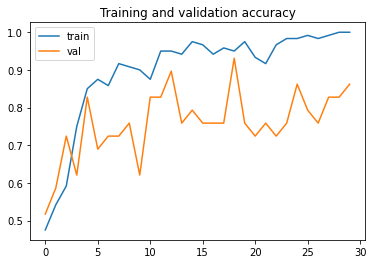

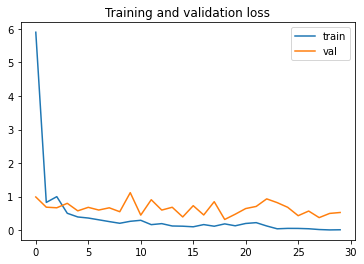

<Figure size 432x288 with 0 Axes>

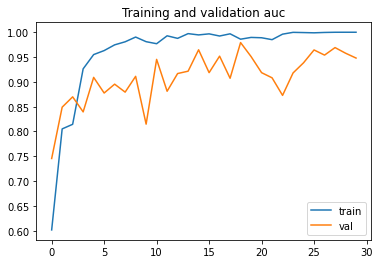

<Figure size 432x288 with 0 Axes>

In [ ]:
# Wydobycie wartości precyji modelu z pliku json
acc = history_basic_model.history['categorical_accuracy']
val_acc = history_basic_model.history['val_categorical_accuracy']

# Wydobycie wartości funkcji kosztu z pliku json
loss = history_basic_model.history['loss']
val_loss = history_basic_model.history['val_loss']

# Wydobycie wartości AUC z pliku json
auc = history_basic_model.history['auc']
val_auc = history_basic_model.history['val_auc']

# Liczba iteracji
epochs = range(len(acc))
plt.figure() # inicjalizacja wykresu
plt.plot(epochs, acc) # dodanie wartości epochs do osi x i acc do osi y
plt.plot(epochs, val_acc) # analogicznie z wartościami na zbiorze walidacyjnym
plt.legend(['train','val']) # dodanie legendy
plt.title('Training and validation accuracy') # Tytuł

plt.figure()
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.legend(['train','val'])
plt.title('Training and validation loss')
plt.figure()

plt.figure()
plt.plot(epochs, auc)
plt.plot(epochs, val_auc)
plt.legend(['train','val'])
plt.title('Training and validation auc')
plt.figure()

Oho, przetrenowany - co teraz? Najlepiej rozszerzyć zbiór danych, ale wtedy nie starczy nam zajęć na naukę modelu. Spróbujmy użyć tzw. regulryzacji L2 w warstwach ukrytych modelu. Intuicyjnie, "regularizer" karze neurony, dzięki czemu małe wagi są spychane do zera - model staje się rzadszy i skupia się na głównych zależnościach w zbiorze.

Dodatkowo, wprowadzimy warstwę Dropout - bardzo silne narzędzie w walce z przetrenowaniem. Dropout wybiera losowo część neuronów, których wagi nie będą aktualizowane w procesie uczenia. Wolimy, żeby neurony były wyspecjalizowane, czyli każdy odpowiada za interpretację pewniej części danych wejściowych.

In [ ]:
# Tworzymy funkcję pomocniczą do definiowania struktury modelu. 
def create_model():
  return tf.keras.Sequential( # Tworzymy obiekt tf.keras.Sequential
      [tf.keras.layers.InputLayer(input_shape = (train_dataset.target_size[0], train_dataset.target_size[1], 3)), # Pierwsza warstwa wejściowa. Etap może zostać pominięty, jeżeli w kolejnej warstwie zostanie podany input_shape
       tf.keras.layers.Conv2D(64, 5,padding = 'same', activation='relu',kernel_regularizer=regularizers.l2(0.01)), # Pierwsza warstwa konwolucyjna
       tf.keras.layers.Conv2D(64, 5,padding = 'same', activation='relu',kernel_regularizer=regularizers.l2(0.01)), # Druga warstwa konwolucyjna
       tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)), # Warstwa MaxPooling
       tf.keras.layers.Conv2D(64, 5,padding = 'same', activation='relu',kernel_regularizer=regularizers.l2(0.01)), # Pierwsza warstwa konwolucyjna
       tf.keras.layers.Conv2D(64, 5,padding = 'same', activation='relu',kernel_regularizer=regularizers.l2(0.01)), # Druga warstwa konwolucyjna
       tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)), # Warstwa MaxPooling
       tf.keras.layers.Conv2D(16, 3,padding = 'same', activation='relu',kernel_regularizer=regularizers.l2(0.01)), # Pierwsza warstwa konwolucyjna
       tf.keras.layers.Conv2D(16, 3,padding = 'same', activation='relu',kernel_regularizer=regularizers.l2(0.01)), # Druga warstwa konwolucyjna
       tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)), # Warstwa MaxPooling
       tf.keras.layers.Flatten(), # Spłaszczenie
       tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)), # Pozostałe warstwy w sieci
       tf.keras.layers.Dense(len(train_dataset.class_indices.values()), activation = 'softmax')]) # ostatnia warstwa posiada tyle neuronów, ile jest etykiet w zbiorze danych
       # funkcja aktywacji softmax jest rozszerzeniem funkcji sigmoid na n wymiarów

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
basic_model = create_model() # basic_model będzie posiadał strukturę zdefiniowaną w funkcji create_model()

basic_model.compile(optimizer='adam', # adam jest jedną ze stochastycznych metod optymalizacji
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC(multi_label=False)]) # możemy dodać wiele metryk, które będą monitorowane w procesie uczenia się
# Jak liczone jest AUC w przypadku multi-classification: https://www.tensorflow.org/api_docs/python/tf/keras/metrics/AUC
# Odnośnie funkcji kosztu(ang): https://gombru.github.io/2018/05/23/cross_entropy_loss/ 
# Odnośnie funkcji kosztu(pl): https://ichi.pro/pl/funkcja-straty-krzyzowej-entropii-267783942726718
basic_model.summary() # funkcja pokazuje nazwę modelu, jego strukturę oraz liczbę parametrów każdej warstwy

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 64)      4864      
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 64)      102464    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        102464    
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 64)        102464    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                    

W procesie uczenia możliwe jest zdefiniowanie dodatkowych własności. Jedną z nich jest <b>EarlyStopping</b>, który monitoruje zmiany podanego parametru w kolejnych iteracjach. Jeżeli są one zbyt niskie (model przestaje się uczyć), proces uczenia jest zatrzymany, a jako końcowe wagi w neuronach zwracane są te, dla któych wartość wskazanego parametru jest najbardziej korzystna (np. najwyższa precyzja, najniższy błąd).

In [ ]:
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, verbose=0, mode='min', restore_best_weights=True)

In [ ]:
# Inicjacja procesu uczenia się sieci neuronowej
# Użyto funkcji fit_generator(), ponieważ dane dostarczane są za pomocą generatora.
# Od niedawna funkcja .fit() również rozumie ten typ danych, więc sugeruję jej użycie w przyszłości.
# Link do opisu wszystkich funkcji w obiekcie Sequential: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
history_basic_model = basic_model.fit_generator(
    train_dataset,
    epochs=50, # Liczba iteracji
    verbose=1, # Informacje zwracane w procesie uczenia się
    callbacks=[early_stop],
    validation_data=val_dataset)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


12/12 [==============================] - 4s 166ms/step - loss: 4.7839 - categorical_accuracy: 0.3750 - auc: 0.5301 - val_loss: 3.5879 - val_categorical_accuracy: 0.3448 - val_auc: 0.5939
Epoch 2/50
12/12 [==============================] - 1s 106ms/step - loss: 2.9622 - categorical_accuracy: 0.4000 - auc: 0.5436 - val_loss: 2.4267 - val_categorical_accuracy: 0.3793 - val_auc: 0.4735
Epoch 3/50
12/12 [==============================] - 1s 103ms/step - loss: 2.1472 - categorical_accuracy: 0.3583 - auc: 0.5441 - val_loss: 1.9131 - val_categorical_accuracy: 0.3103 - val_auc: 0.5217
Epoch 4/50
12/12 [==============================] - 1s 109ms/step - loss: 1.7818 - categorical_accuracy: 0.3500 - auc: 0.5746 - val_loss: 1.6509 - val_categorical_accuracy: 0.5517 - val_auc: 0.7313
Epoch 5/50
12/12 [==============================] - 1s 119ms/step - loss: 1.5475 - categorical_accuracy: 0.4417 - auc: 0.6420 - val_loss: 1.4344 - val_categorical_accuracy: 0.5172 - val_auc: 0.7663
Epoch 6/50
12/12 [===

<Figure size 432x288 with 0 Axes>

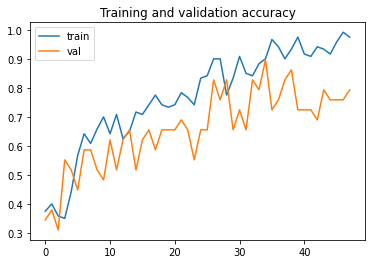

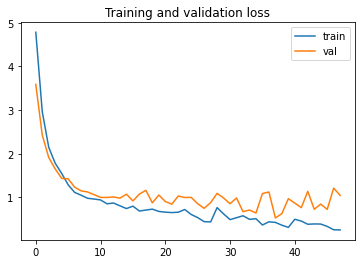

<Figure size 432x288 with 0 Axes>

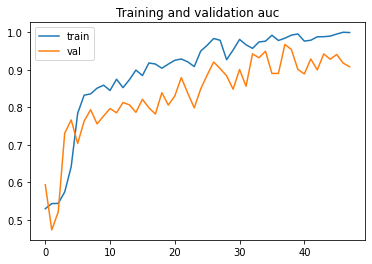

<Figure size 432x288 with 0 Axes>

In [ ]:
# Wydobycie wartości accuracy
acc = history_basic_model.history['categorical_accuracy']
val_acc = history_basic_model.history['val_categorical_accuracy']

# Wydobycie wartości błędu uczenia
loss = history_basic_model.history['loss']
val_loss = history_basic_model.history['val_loss']

# Wydobycie wartości AUC
auc = history_basic_model.history['auc']
val_auc = history_basic_model.history['val_auc']

# Liczba iteracji
epochs = range(len(acc))
plt.figure() # inicjalizacja wykresu
plt.plot(epochs, acc) # dodanie wartości epochs do osi x i acc do osi y
plt.plot(epochs, val_acc) # analogicznie z wartościami na zbiorze walidacyjnym
plt.legend(['train','val']) # dodanie legendy
plt.title('Training and validation accuracy') # Tytuł

plt.figure()
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.legend(['train','val'])
plt.title('Training and validation loss')
plt.figure()

plt.figure()
plt.plot(epochs, auc)
plt.plot(epochs, val_auc)
plt.legend(['train','val'])
plt.title('Training and validation auc')
plt.figure()

Dla porównania - przebieg treningu sieci neuronowej o identycznej strukturze przy użyciu pełnego zbioru danych - proszę zwrócić na różnice w czasie obliczeniowym przy każdej iteracji.

In [ ]:
# history_basic_model = basic_model.fit_generator(
#     train_dataset,
#     epochs=30, # Liczba iteracji
#     verbose=1, # Informacje zwracane w procesie uczenia się
#     callbacks=None,
#     validation_data=val_dataset)

<b> BARDZO WAŻNE! </b>

W momencje, gdy trenowany jest nowy model, środowisko wykonawcze powinno zostać zresetowane. Dopóki nie zostaniemy odłączeni od GPU, kolejne iteracje trwają po ~1min.
Jeżeli nie zresetujemy środowiska, w pamięci pozostaną obiekty, przez które jakość kolejnych modeli będzie zdecydowanie zawyżona.
Używając CPU istnieje opcja wyczyszczenia środowiska bez jego resetowania: 
https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session
https://www.tensorflow.org/api_docs/python/tf/compat/v1/reset_default_graph
<br>Używając GPU należy uruchomić ponownie środowisko wykonawcze.

In [ ]:
# Zapisywnie modelu 
# Format .h5 zajmuje dużo pamięci, jednak jest o tyle wygodny, że jest to jeden plik. Nie jest to jednak jedyna opcja zapisywania modelu.
# https://www.tensorflow.org/api_docs/python/tf/keras/models/save_model
basic_model.save('models/basic_model_light.h5')

In [ ]:
# Wczytywanie modelu 
basic_model =  tf.keras.models.load_model('models/basic_model_light.h5')

In [ ]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
  
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
# Predykcje przy użyciu modelu
# Należy ustawić parametr .shuffle na False, aby generator nie pokazywał losowo zdjęć do predykcji. Ułatwia to walidację wyników.
test_dataset.shuffle=False
y_pred = basic_model.predict_generator(test_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


In [ ]:
# .predict_generator zwraca wartości w postaci wektorów 3 wymiarowych
# Wartości mogą być interpretowane jako prawdopodobieństwo klasyfikacji do danej etykiety.
y_pred

array([[4.80606109e-01, 2.61477944e-05, 5.19367754e-01],
       [6.16487503e-01, 1.17909715e-01, 2.65602767e-01],
       [6.58752799e-01, 1.52715877e-01, 1.88531354e-01],
       [8.16978693e-01, 5.55095151e-02, 1.27511829e-01],
       [3.41355771e-01, 5.75830266e-02, 6.01061225e-01],
       [7.64786720e-01, 1.65018737e-01, 7.01945052e-02],
       [4.27996576e-01, 2.58067641e-02, 5.46196640e-01],
       [8.15170348e-01, 3.30985859e-02, 1.51731074e-01],
       [5.28436184e-01, 5.21304319e-03, 4.66350824e-01],
       [4.46707159e-01, 5.48464432e-02, 4.98446405e-01],
       [8.33362862e-02, 8.98001492e-01, 1.86622888e-02],
       [1.07605644e-01, 8.61249149e-01, 3.11452560e-02],
       [6.18459992e-02, 9.27548230e-01, 1.06057208e-02],
       [4.76522505e-01, 4.45581079e-01, 7.78963640e-02],
       [3.10208559e-01, 5.89277267e-01, 1.00514218e-01],
       [4.20202240e-02, 9.50832963e-01, 7.14678736e-03],
       [5.40627204e-02, 9.38552976e-01, 7.38435658e-03],
       [1.27435833e-01, 8.57184

In [ ]:
# Predykcje klas. np.argmax zwraca indeks kolumny z najwyższą wartością.
y_pred_classes = np.argmax(y_pred,axis = 1)
y_pred_classes

array([2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 2])

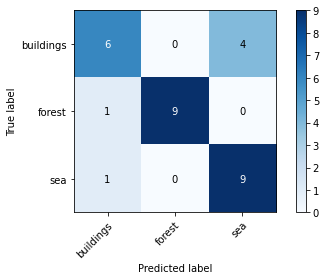

In [ ]:
# Wykres macierzy błędu
target_names = ['buildings', 'forest', 'sea']
plot_confusion_matrix(test_dataset.classes, y_pred_classes,classes=target_names)

In [ ]:
# Moduł sklearn.metrics pozwala na automatyczne obliczenie bardziej skomplikowanych metryk.
print('Confusion Matrix')
print(metrics.confusion_matrix(test_dataset.classes, y_pred_classes))
print('Classification Report')
print(metrics.classification_report(test_dataset.classes, y_pred_classes, target_names=target_names))
print('Accuracy = '+ str(metrics.accuracy_score(test_dataset.classes,y_pred_classes)))

Confusion Matrix
[[6 0 4]
 [1 9 0]
 [1 0 9]]
Classification Report
              precision    recall  f1-score   support

   buildings       0.75      0.60      0.67        10
      forest       1.00      0.90      0.95        10
         sea       0.69      0.90      0.78        10

    accuracy                           0.80        30
   macro avg       0.81      0.80      0.80        30
weighted avg       0.81      0.80      0.80        30

Accuracy = 0.8


### Zadanie 1

Zamień model, aby miał:<ul>
<li>1 warstwę conv i maxpooling</li>
<li>3 warstwy conv i maxpooling (na zmianę)</li>
<li>zwiększ/zmniejsz kernel_size</li>
<li>zwiększ/zmniejsz pool_size</li>
<li>zwiększ/zmniejsz strides</li>
</ul>

Jaki model osiągnął najniższe wartości metryki błędu? Który był najmniej przetrenowany?

In [ ]:
tf.keras.backend.clear_session()

## Transfer learning z wykorzystaniem modelu VGG16.

Model VGG16 został wytrenowany na zbiorze ponad 15 milionów zdjęć przyporządkowanych do 22 tysięcy kategorii. Proces uczenia VGG16 trwał tygodnie. Środowisko wykonawcze wyposarzone było w NVIDIA Titan Black GPU’s.

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
vgg_conv=VGG16(weights='imagenet', include_top=False,input_shape=(train_dataset.target_size[0], train_dataset.target_size[1], 3))
# parametr include_top = False odpowiada za to, że użyte zostaną jedynie warstwy konwolucyjne oraz maxpool z wagami 

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg_conv.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

<a href="https://neurohive.io/en/popular-networks/vgg16/">Link</a> do pełnego opisu modelu VGG16.<br>
Lista pozostałych modeli dostępnych w tf.keras dostępa <a href="https://www.tensorflow.org/api_docs/python/tf/keras/applications">tutaj</a>.

In [ ]:
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=15, verbose=0, mode='min', restore_best_weights=True)

In [ ]:
# Różnica w transfer learning polega na tym, że używamy wytrenowanego modelu do rozwiązania nowych problemów.
# Za część konwolucyjną w nowym modelu odpowiada VGG16, pozostałe warstwy są dostosowane do analizowanego zbioru danych.
def create_transfer_learning_model():
  return tf.keras.Sequential(
      [vgg_conv,
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(256, activation='relu'),
       tf.keras.layers.Dense(len(train_dataset.class_indices.values()), activation='softmax')])

In [ ]:
transfer_learning_model = create_transfer_learning_model()

transfer_learning_model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC(multi_label=False)])
transfer_learning_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 16,812,867
Trainable params: 16,812,867
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_transfer_learning_model = transfer_learning_model.fit_generator(
    train_dataset, epochs=100, verbose=1,
    validation_data=val_dataset,
    callbacks=[early_stop])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


12/12 [==============================] - 6s 239ms/step - loss: 3.4157 - categorical_accuracy: 0.3500 - auc_1: 0.4795 - val_loss: 1.6636 - val_categorical_accuracy: 0.3448 - val_auc_1: 0.4498
Epoch 2/100
12/12 [==============================] - 2s 125ms/step - loss: 1.1372 - categorical_accuracy: 0.3333 - auc_1: 0.5274 - val_loss: 1.1012 - val_categorical_accuracy: 0.3103 - val_auc_1: 0.5755
Epoch 3/100
12/12 [==============================] - 2s 124ms/step - loss: 1.1004 - categorical_accuracy: 0.3833 - auc_1: 0.5401 - val_loss: 1.0907 - val_categorical_accuracy: 0.3103 - val_auc_1: 0.6210
Epoch 4/100
12/12 [==============================] - 2s 123ms/step - loss: 1.0512 - categorical_accuracy: 0.4167 - auc_1: 0.6310 - val_loss: 0.8389 - val_categorical_accuracy: 0.7241 - val_auc_1: 0.8668
Epoch 5/100
12/12 [==============================] - 2s 125ms/step - loss: 0.9183 - categorical_accuracy: 0.5667 - auc_1: 0.7646 - val_loss: 0.6793 - val_categorical_accuracy: 0.6552 - val_auc_1: 0.88

In [ ]:
history_transfer_learning_model.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'auc_1', 'val_loss', 'val_categorical_accuracy', 'val_auc_1'])

<Figure size 432x288 with 0 Axes>

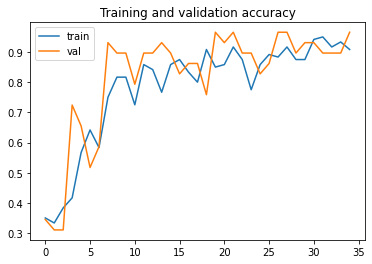

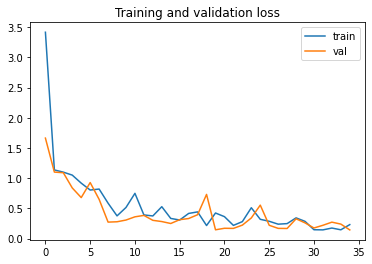

<Figure size 432x288 with 0 Axes>

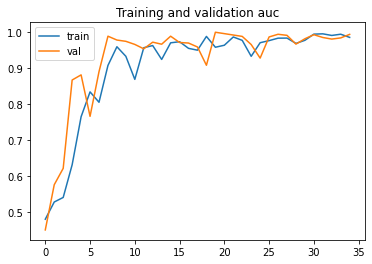

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history_transfer_learning_model.history['categorical_accuracy']
val_acc = history_transfer_learning_model.history['val_categorical_accuracy']

loss = history_transfer_learning_model.history['loss']
val_loss = history_transfer_learning_model.history['val_loss']

auc = history_transfer_learning_model.history['auc_1']
val_auc = history_transfer_learning_model.history['val_auc_1']

epochs = range(len(acc))
plt.figure()
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.legend(['train','val'])
plt.title('Training and validation accuracy')

plt.figure()
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.legend(['train','val'])
plt.title('Training and validation loss')
plt.figure()

plt.figure()
plt.plot(epochs, auc)
plt.plot(epochs, val_auc)
plt.legend(['train','val'])
plt.title('Training and validation auc')
plt.figure()

In [ ]:
test_dataset.shuffle=False

In [ ]:
test_dataset.shuffle=False
y_pred = transfer_learning_model.predict_generator(test_dataset)
# np.save('models/y_pred_transfer_learning_model.npy',y_pred)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


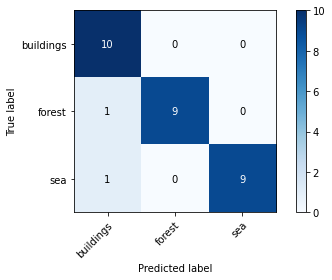

In [ ]:
y_pred_classes = np.argmax(y_pred,axis = 1)
target_names = ['buildings', 'forest', 'sea']
plot_confusion_matrix(test_dataset.classes, y_pred_classes,classes=target_names)

In [ ]:
print('Confusion Matrix')
print(metrics.confusion_matrix(test_dataset.classes, y_pred_classes))
print('Classification Report')
print(metrics.classification_report(test_dataset.classes, y_pred_classes, target_names=target_names))
print('Accuracy = '+ str(metrics.accuracy_score(test_dataset.classes,y_pred_classes)))

Confusion Matrix
[[10  0  0]
 [ 1  9  0]
 [ 1  0  9]]
Classification Report
              precision    recall  f1-score   support

   buildings       0.83      1.00      0.91        10
      forest       1.00      0.90      0.95        10
         sea       1.00      0.90      0.95        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30

Accuracy = 0.9333333333333333


Wykorzystanie transfer learningu istotnie zwiększyło precyzję modelu, jednocześnie zmniejszając jego przetrenowanie.<br>
Należy zadać sobie pytanie, czy istotniejsza jest większa liczba warstw konwolucyjnych użyta w modelu, czy też wagi w warstwach dostosowane podczas długiego procesu uczenia się modelu VGG16.

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
advanced_model = Sequential()
advanced_model.add(Conv2D(input_shape=(train_dataset.target_size[0],train_dataset.target_size[1],3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
advanced_model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
advanced_model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
advanced_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
advanced_model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
advanced_model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
advanced_model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
advanced_model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
advanced_model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
advanced_model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
advanced_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
advanced_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
advanced_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
advanced_model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
advanced_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
advanced_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
advanced_model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
advanced_model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
advanced_model.add(Flatten())
advanced_model.add(Dense(units=4008,activation="relu"))
advanced_model.add(Dense(units=3, activation="softmax"))

In [ ]:
advanced_model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC(multi_label=False)])

In [ ]:
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, verbose=0, mode='min', restore_best_weights=True)

In [ ]:
advanced_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 128)      0         
 2D)                                                    

In [ ]:
history_advanced_model = advanced_model.fit_generator(
    train_dataset, epochs=30, verbose=1,
    validation_data=val_dataset,
    callbacks=[early_stop])

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


12/12 [==============================] - 3s 185ms/step - loss: 1.8525 - categorical_accuracy: 0.3083 - auc: 0.4752 - val_loss: 1.0978 - val_categorical_accuracy: 0.3448 - val_auc: 0.5172
Epoch 2/30
12/12 [==============================] - 2s 125ms/step - loss: 1.0998 - categorical_accuracy: 0.2917 - auc: 0.4653 - val_loss: 1.0979 - val_categorical_accuracy: 0.3448 - val_auc: 0.5172
Epoch 3/30
12/12 [==============================] - 2s 124ms/step - loss: 1.0998 - categorical_accuracy: 0.2917 - auc: 0.4717 - val_loss: 1.0978 - val_categorical_accuracy: 0.3448 - val_auc: 0.5172
Epoch 4/30
12/12 [==============================] - 2s 125ms/step - loss: 1.1001 - categorical_accuracy: 0.2250 - auc: 0.4514 - val_loss: 1.0980 - val_categorical_accuracy: 0.3448 - val_auc: 0.5172
Epoch 5/30
12/12 [==============================] - 2s 124ms/step - loss: 1.0995 - categorical_accuracy: 0.3333 - auc: 0.4917 - val_loss: 1.0984 - val_categorical_accuracy: 0.3448 - val_auc: 0.5172
Epoch 6/30
12/12 [===

Wniosek: Używanie takiej samej struktury jak w VGG16 bez uwzględnienia wag warstw konwolucyjnych nie skutkuje wyższymi wartościami precyzji modelu.

## Wizualizacja warstw konwolucyjnych.

Warstwy konwolucyjne odpowiadają za wydobycie najistotniejszych elementów zdjęć, które wpływają na decyzję o ich klasyfikacji do danych etykiet. W tensorflow keras możliwe jest stworzenie modelu, który zwraca wynik dowolnej warstwy z uprzednio wyrrenowanego modelu.

In [ ]:
# Tworzymy funkcję pomocniczą do definiowania struktury modelu. 
def create_model():
  return tf.keras.Sequential( # Tworzymy obiekt tf.keras.Sequential
      [tf.keras.layers.InputLayer(input_shape = (train_dataset.target_size[0], train_dataset.target_size[1], 3)), # Pierwsza warstwa wejściowa. Etap może zostać pominięty, jeżeli w kolejnej warstwie zostanie podany input_shape
       tf.keras.layers.Conv2D(64, 3,padding = 'same', activation='relu'), # Pierwsza warstwa konwolucyjna
       tf.keras.layers.Conv2D(64, 3,padding = 'same', activation='relu'), # Druga warstwa konwolucyjna
       tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=(2,2)), # Warstwa MaxPooling
       tf.keras.layers.Conv2D(32, 2,padding = 'same', activation='relu'), # Pierwsza warstwa konwolucyjna
       tf.keras.layers.Conv2D(32, 2,padding = 'same', activation='relu'), # Druga warstwa konwolucyjna
       tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)), # Warstwa MaxPooling
       tf.keras.layers.Flatten(), # Spłaszczenie
       tf.keras.layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.01)), # Pozostałe warstwy w sieci
       tf.keras.layers.Dense(len(train_dataset.class_indices.values()), activation = 'softmax')]) # ostatnia warstwa posiada tyle neuronów, ile jest etykiet w zbiorze danych
       # funkcja aktywacji softmax jest rozszerzeniem funkcji sigmoid na n wymiarów

In [ ]:
basic_model = create_model() # basic_model będzie posiadał strukturę zdefiniowaną w funkcji create_model()

basic_model.compile(optimizer='adam', # adam jest jedną ze stochastycznych metod optymalizacji
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC(multi_label=False)]) # możemy dodać wiele metryk, które będą monitorowane w procesie uczenia się
# Jak liczone jest AUC w przypadku multi-classification: https://www.tensorflow.org/api_docs/python/tf/keras/metrics/AUC
# Odnośnie funkcji kosztu(ang): https://gombru.github.io/2018/05/23/cross_entropy_loss/ 
# Odnośnie funkcji kosztu(pl): https://ichi.pro/pl/funkcja-straty-krzyzowej-entropii-267783942726718
basic_model.summary() # funkcja pokazuje nazwę modelu, jego strukturę oraz liczbę parametrów każdej warstwy

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 150, 150, 64)      1792      
                                                                 
 conv2d_14 (Conv2D)          (None, 150, 150, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 74, 74, 32)        8224      
                                                                 
 conv2d_16 (Conv2D)          (None, 74, 74, 32)        4128      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                  

In [ ]:
history_basic_model = basic_model.fit_generator(
    train_dataset,
    epochs=30, # Liczba iteracji
    verbose=1, # Informacje zwracane w procesie uczenia się
    validation_data=val_dataset,
    callbacks=[early_stop])

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


12/12 [==============================] - 2s 133ms/step - loss: 3.8522 - categorical_accuracy: 0.3333 - auc_1: 0.5183 - val_loss: 2.2101 - val_categorical_accuracy: 0.5862 - val_auc_1: 0.5916
Epoch 2/30
12/12 [==============================] - 1s 103ms/step - loss: 1.9562 - categorical_accuracy: 0.4917 - auc_1: 0.7366 - val_loss: 1.5375 - val_categorical_accuracy: 0.5862 - val_auc_1: 0.7922
Epoch 3/30
12/12 [==============================] - 1s 105ms/step - loss: 1.2507 - categorical_accuracy: 0.6083 - auc_1: 0.8323 - val_loss: 1.0926 - val_categorical_accuracy: 0.6897 - val_auc_1: 0.8517
Epoch 4/30
12/12 [==============================] - 1s 105ms/step - loss: 0.9498 - categorical_accuracy: 0.6917 - auc_1: 0.8817 - val_loss: 0.9320 - val_categorical_accuracy: 0.6897 - val_auc_1: 0.8683
Epoch 5/30
12/12 [==============================] - 1s 102ms/step - loss: 0.8362 - categorical_accuracy: 0.7167 - auc_1: 0.8945 - val_loss: 0.7917 - val_categorical_accuracy: 0.7931 - val_auc_1: 0.9090
E

In [ ]:
basic_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 150, 150, 64)      1792      
                                                                 
 conv2d_14 (Conv2D)          (None, 150, 150, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 74, 74, 32)        8224      
                                                                 
 conv2d_16 (Conv2D)          (None, 74, 74, 32)        4128      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                  

In [ ]:
# Warstwa wejściowa jest taka jaka jak w podstawowym modelu. 
# Warstwą wyjściową jest pierwsza warstwa ukryta w basic_model, czyli pierwsza warstwa konwolucyjna.
# Link do artykułu, w którym opisany jest cały proces: https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/
visualize_conv_model = tf.keras.Model(inputs=basic_model.inputs, outputs=basic_model.layers[1].output)

In [ ]:
# Pierwsze 10 zdjęć z kolejnego wsadu
x,y = train_dataset.next()

In [ ]:
# feature_maps jest listą, w której zapisywane będą wyniki predykcji modelu
feature_maps =[]
for i in range(10):
  feature_maps.append(visualize_conv_model.predict(np.expand_dims(x[i],axis = 0)))
  # np.expand_dims dodaje wymiar do obiektu x[i] (czyli i-tego zdjęcia). Dzięki temu model wie, że predykcja wykonywana jest dla jednego zdjęcia
  # zamiast (150,150,3) model przyjmuje dane (1,150,150,3)

In [ ]:
# Pierwsza warstwa konwolucyjna ma 64 osobnych filtrów, czyli produkuje 64 osobnych predykcji dla jednego zdjęcia
square = 8 # Rysunek będzie zawierał 64 subploty ustawione w 8 kolumnach i 8 wierszach
ix = 1
for j in range(10):
  image = x[j]
  plt.imshow(image) # Dla porównania, oryginalne zdjęcie
  plt.title(y[i])
  plt.show()
  fig = plt.figure(figsize=(25, 8))
  for _ in range(square):
    for _ in range(square):
      ax = fig.add_subplot(square, square, ix)
      ax.set_xticks([])
      ax.set_yticks([])
      plt.imshow(feature_maps[j][0, :, :, ix-1], cmap='hot')
      ix += 1
  plt.show()
  ix = 1

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#wizualizacja 2 warstwy 
visualize_conv2_model = tf.keras.Model(inputs=basic_model.inputs, outputs=basic_model.layers[2].output)

In [ ]:
feature_maps_2 =[]
for i in range(10):
  feature_maps_2.append(visualize_conv2_model.predict(np.expand_dims(x[i],axis = 0)))

In [ ]:
square = 8
ix = 1
for j in range(10):
  image = x[j]
  plt.imshow(image)
  plt.title(y[i])
  plt.show()
  fig = plt.figure(figsize=(25, 8))
  for _ in range(square):
    for _ in range(square):
      ax = fig.add_subplot(square, square, ix)
      ax.set_xticks([])
      ax.set_yticks([])
      plt.imshow(feature_maps_2[j][0, :, :, ix-1], cmap='hot')
      ix += 1
  plt.show()
  ix = 1

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#Wizualizacja warstwy max_pooling
visualize_max_pooling_model = tf.keras.Model(inputs=basic_model.inputs, outputs=basic_model.layers[3].output)

In [ ]:
feature_maps_3 =[]
for i in range(10):
  feature_maps_3.append(visualize_max_pooling_model.predict(np.expand_dims(x[i],axis = 0)))

In [ ]:
square = 8
ix = 1
for j in range(10):
  image = x[j]
  plt.imshow(image)
  plt.title(y[i])
  plt.show()
  fig = plt.figure(figsize=(25, 8))
  for _ in range(square):
    for _ in range(square):
      ax = fig.add_subplot(square, square, ix)
      ax.set_xticks([])
      ax.set_yticks([])
      plt.imshow(feature_maps_3[j][0, :, :, ix-1], cmap='hot')
      ix += 1
  plt.show()
  ix = 1

## XAI

https://jacobgil.github.io/deeplearning/class-activation-maps

https://github.com/philipperemy/tensorflow-class-activation-mapping

https://medium.com/intelligentmachines/implementation-of-class-activation-map-cam-with-pytorch-c32f7e414923

In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 5.2 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=be41c2004ee50f6aa24a5c948f6fcd000ecfc1815d82f7b1dd898061bcf26136
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random

In [ ]:
# Pierwsze 10 zdjęć z kolejnego wsadu
x,y = train_dataset.next()

In [ ]:
select_image = x[7]

In [ ]:
img = tf.keras.preprocessing.image.img_to_array(select_image)
data = ([img], None)

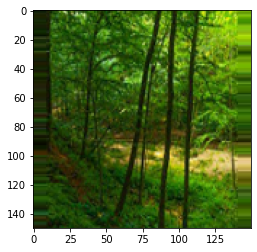

In [ ]:
plt.imshow(img, cmap='hot')
plt.show()

In [ ]:
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(
         select_image.astype('double'), 
         basic_model.predict
)


  0%|          | 0/1000 [00:00<?, ?it/s]

(-0.5, 149.5, 149.5, -0.5)

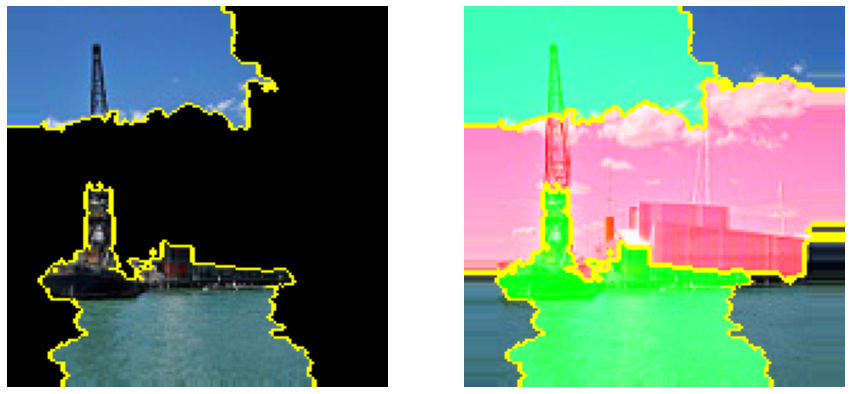

In [ ]:
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

In [ ]:
!pip install tf-explain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.0 MB/s 


In [ ]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tf_explain

In [ ]:
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.integrated_gradients import IntegratedGradients
from tf_explain.core.smoothgrad import SmoothGrad

In [ ]:
grad_explainer = GradCAM()
grad_grid = grad_explainer.explain(data, basic_model, class_index=1)

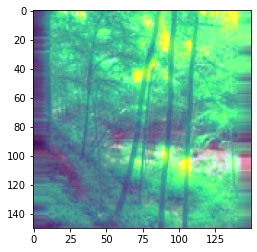

In [ ]:
plt.imshow(grad_grid)
plt.show()

In [ ]:
integrated_explainer = IntegratedGradients()
integrated_grid = integrated_explainer.explain(data, basic_model, class_index=2)

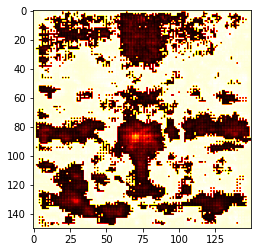

In [ ]:
plt.imshow(integrated_grid, cmap='hot')
plt.show()

## Zrób to sam!

In [ ]:
# Obiekty ImageDataGenerator decyduje o tym, jakie operacje zostaną wykonane na zdjęciach podczas wgrywania do sesji.
# link: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255, # skalowanie zdjęć
                                   shear_range = 0.2, # losowo przycina zdjęcia
                                   zoom_range = 0.2, # losowo przybliża zdjęcia
                                   validation_split = 0., # zdjęcia z folderu train zostaną automatycznie podzielone na część treningową i walidacyjną w proporji 0.8/0.2
                                   horizontal_flip = True) # przekręca losowe zdjęcia horyzontalnie
val_datagen = ImageDataGenerator(rescale = 1./255)
# Na zbiorze testowym nie są wykonywane żadne dodatkowe operacje.
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
%cd /content/gdrive/My Drive/AI_datasets

/content/gdrive/My Drive/AI_datasets


In [ ]:
!ls

 2017_Financial_Data.csv      'Intel Image Classification demo'
 CarPrice_Assignment.csv       logs
 house_price_prediction.csv    Lyrics
 insurance.csv		       marketing_campaign.csv
 insurance_kz.csv	       Music_genre
'Intel Image Classification'   planesnet_split


In [ ]:
%cd planesnet_split
# ustaw odpowiednią ścieżkę

# flow_from_directory przypisuje zdjęcia z odpowiednich folderów do obiektów w batches. Wszystkie zdjęcia nie są od razu dostępne w np. train_dataset,
# gdyż jest to kolejny obiekt z wieloma funkcjami. Odpowiednie zdjęcia są ładowane w batches podczas trenowania modelu.
train_dataset = train_datagen.flow_from_directory('train', # nazwa podfolderu
                                                  target_size = (32, 32), # rozmiar zdjęcia
                                                  batch_size = 80) # podzbiór treningowy lub walidacyjny
val_dataset = val_datagen.flow_from_directory('val',
                                                target_size = (32, 32),
                                                batch_size = 80)
test_dataset = test_datagen.flow_from_directory('test',
                                            target_size = (32, 32),
                                            batch_size = 80)

/content/gdrive/My Drive/AI_datasets/planesnet_split
Found 1920 images belonging to 2 classes.
Found 640 images belonging to 2 classes.
Found 640 images belonging to 2 classes.


In [ ]:
# Tworzymy funkcję pomocniczą do definiowania struktury modelu. 
def create_model():
  return tf.keras.Sequential( # Tworzymy obiekt tf.keras.Sequential
      [tf.keras.layers.InputLayer(input_shape = (train_dataset.target_size[0], train_dataset.target_size[1], 3)), # Pierwsza warstwa wejściowa. Etap może zostać pominięty, jeżeli w kolejnej warstwie zostanie podany input_shape
       tf.keras.layers.Conv2D(64, 5,padding = 'same', activation='relu',kernel_regularizer=regularizers.l2(0.01)), # Pierwsza warstwa konwolucyjna
       tf.keras.layers.Conv2D(64, 3,padding = 'valid', activation='relu',kernel_regularizer=regularizers.l2(0.01)), # Druga warstwa konwolucyjna
       tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)), # Warstwa MaxPooling
       tf.keras.layers.Conv2D(64, 2,padding = 'valid', activation='relu',kernel_regularizer=regularizers.l2(0.01)), # Druga warstwa konwolucyjna
       tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)), # Warstwa MaxPooling
       tf.keras.layers.Flatten(), # Spłaszczenie
       tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)), # Pozostałe warstwy w sieci
       tf.keras.layers.Dense(len(train_dataset.class_indices.values()), activation = 'softmax')]) # ostatnia warstwa posiada tyle neuronów, ile jest etykiet w zbiorze danych
       # funkcja aktywacji softmax jest rozszerzeniem funkcji sigmoid na n wymiarów

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
basic_model = create_model() # basic_model będzie posiadał strukturę zdefiniowaną w funkcji create_model()

basic_model.compile(optimizer='adam', # adam jest jedną ze stochastycznych metod optymalizacji
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC(multi_label=False)]) # możemy dodać wiele metryk, które będą monitorowane w procesie uczenia się
# Jak liczone jest AUC w przypadku multi-classification: https://www.tensorflow.org/api_docs/python/tf/keras/metrics/AUC
# Odnośnie funkcji kosztu(ang): https://gombru.github.io/2018/05/23/cross_entropy_loss/ 
# Odnośnie funkcji kosztu(pl): https://ichi.pro/pl/funkcja-straty-krzyzowej-entropii-267783942726718
basic_model.summary() # funkcja pokazuje nazwę modelu, jego strukturę oraz liczbę parametrów każdej warstwy

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        4864      
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        16448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0

In [ ]:
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=25, verbose=0, mode='min', restore_best_weights=True)

In [ ]:
# Inicjacja procesu uczenia się sieci neuronowej
# Użyto funkcji fit_generator(), ponieważ dane dostarczane są za pomocą generatora.
# Od niedawna funkcja .fit() również rozumie ten typ danych, więc sugeruję jej użycie w przyszłości.
# Link do opisu wszystkich funkcji w obiekcie Sequential: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
history_basic_model = basic_model.fit_generator(
    train_dataset,
    epochs=50, # Liczba iteracji
    verbose=1, # Informacje zwracane w procesie uczenia się
    callbacks=[early_stop],
    validation_data=val_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


24/24 [==============================] - 240s 10s/step - loss: 2.9486 - categorical_accuracy: 0.7312 - auc: 0.7103 - val_loss: 1.7926 - val_categorical_accuracy: 0.7500 - val_auc: 0.6389
Epoch 2/50
24/24 [==============================] - 4s 169ms/step - loss: 1.3678 - categorical_accuracy: 0.7500 - auc: 0.7283 - val_loss: 1.0482 - val_categorical_accuracy: 0.7500 - val_auc: 0.6355
Epoch 3/50
24/24 [==============================] - 4s 169ms/step - loss: 0.9076 - categorical_accuracy: 0.7500 - auc: 0.7626 - val_loss: 0.7801 - val_categorical_accuracy: 0.7500 - val_auc: 0.8682
Epoch 4/50
24/24 [==============================] - 4s 170ms/step - loss: 0.7125 - categorical_accuracy: 0.7500 - auc: 0.8340 - val_loss: 0.6154 - val_categorical_accuracy: 0.7500 - val_auc: 0.8773
Epoch 5/50
24/24 [==============================] - 4s 170ms/step - loss: 0.5995 - categorical_accuracy: 0.7500 - auc: 0.8643 - val_loss: 0.5453 - val_categorical_accuracy: 0.7500 - val_auc: 0.8791
Epoch 6/50
24/24 [===

<Figure size 432x288 with 0 Axes>

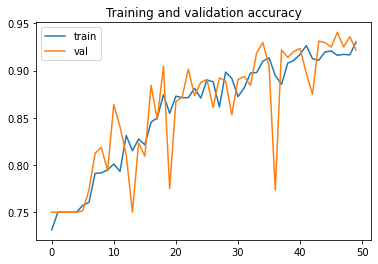

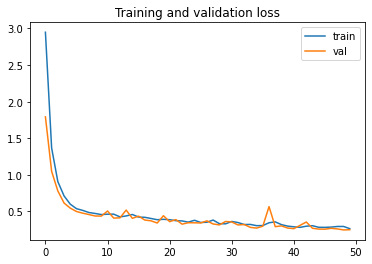

<Figure size 432x288 with 0 Axes>

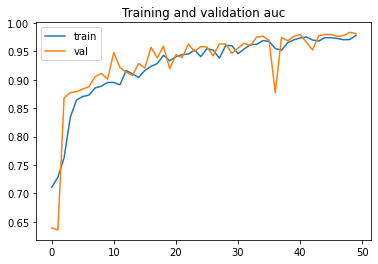

<Figure size 432x288 with 0 Axes>

In [ ]:
# Wydobycie wartości accuracy
acc = history_basic_model.history['categorical_accuracy']
val_acc = history_basic_model.history['val_categorical_accuracy']

# Wydobycie wartości błędu uczenia
loss = history_basic_model.history['loss']
val_loss = history_basic_model.history['val_loss']

# Wydobycie wartości AUC
auc = history_basic_model.history['auc']
val_auc = history_basic_model.history['val_auc']

# Liczba iteracji
epochs = range(len(acc))
plt.figure() # inicjalizacja wykresu
plt.plot(epochs, acc) # dodanie wartości epochs do osi x i acc do osi y
plt.plot(epochs, val_acc) # analogicznie z wartościami na zbiorze walidacyjnym
plt.legend(['train','val']) # dodanie legendy
plt.title('Training and validation accuracy') # Tytuł

plt.figure()
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.legend(['train','val'])
plt.title('Training and validation loss')
plt.figure()

plt.figure()
plt.plot(epochs, auc)
plt.plot(epochs, val_auc)
plt.legend(['train','val'])
plt.title('Training and validation auc')
plt.figure()

In [ ]:
# Pierwsze 10 zdjęć z kolejnego wsadu
x,y = train_dataset.next()

In [ ]:
select_image = x[4]

In [ ]:
img = tf.keras.preprocessing.image.img_to_array(select_image)
data = ([img], None)

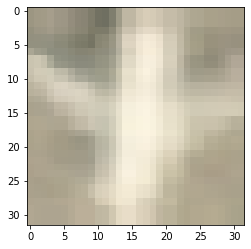

In [ ]:
plt.imshow(img, cmap='hot')
plt.show()

In [ ]:
explainer = lime_image.LimeImageExplainer(kernel_width = 0.05, random_state=42)
explanation = explainer.explain_instance(
         select_image.astype('double'), 
         basic_model.predict
)


  0%|          | 0/1000 [00:00<?, ?it/s]

(-0.5, 31.5, 31.5, -0.5)

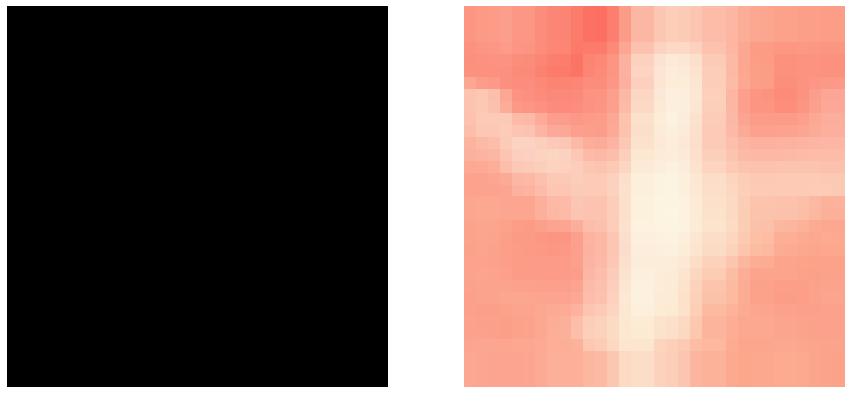

In [ ]:
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=True, num_features=50, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=False, num_features=50, hide_rest=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

In [ ]:
vgg_conv=VGG16(weights='imagenet', include_top=False,input_shape=(train_dataset.target_size[0], train_dataset.target_size[1], 3))
# parametr include_top = False odpowiada za to, że użyte zostaną jedynie warstwy konwolucyjne oraz maxpool z wagami 

2 modele bez TL
1 modele z TL

In [ ]:
# Zastanów się nad wagą klas i dodatkowymi usprawnieniami procesu uczenia się sieci

In [ ]:
# Zwizualizuj wyniki modelu, przeanalizuj wizualizacje warstw konwolucyjnych - LIME. Jakie elemety zdjęć ułatwiły sieci klasyfikację? 

# Coś dla muzycznych świrów

Jak analizować dane muzyczne? Pewnie trzeba mieć specjalną architekturę pod pliki audio...<br>
Otóż niekoniecznie, CNN świetnie się sprawdzają w tego rodzaju zadaniach!  Wystarczy stworzyć obrazową reprezentację dźwięku, na przykład przy pomocy spektrogramu, który pokazuje czas i amplitudę widmową
przedstawianą za pomocą barwy lub intensywności

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,)

In [ ]:
%cd /content/gdrive/My Drive/AI_datasets

/content/gdrive/My Drive/AI_datasets


In [ ]:
!ls

 2017_Financial_Data.csv	    logs
 CarPrice_Assignment.csv	    Lyrics
 house_price_prediction.csv	    marketing_campaign.csv
 insurance.csv			    Music_genre
'Intel Image Classification'	    planesnet_split
'Intel Image Classification demo'


In [ ]:
# %cd Music_genre
# ustaw odpowiednią ścieżkę

# flow_from_directory przypisuje zdjęcia z odpowiednich folderów do obiektów w batches. Wszystkie zdjęcia nie są od razu dostępne w np. train_dataset,
# gdyż jest to kolejny obiekt z wieloma funkcjami. Odpowiednie zdjęcia są ładowane w batches podczas trenowania modelu.
train_dataset = train_datagen.flow_from_directory('Music_genre', # nazwa podfolderu
                                                  target_size = (int(432/2), int(288/2)), # rozmiar zdjęcia
                                                  batch_size = 10,
                                                  subset = 'training') # podzbiór treningowy lub walidacyjny
val_dataset = train_datagen.flow_from_directory('Music_genre',
                                                target_size = (int(432/2), int(288/2)),
                                                batch_size = 10,
                                                subset = 'validation')

Found 800 images belonging to 10 classes.
Found 199 images belonging to 10 classes.


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


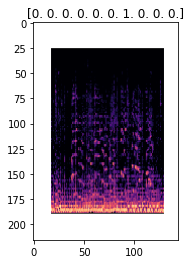

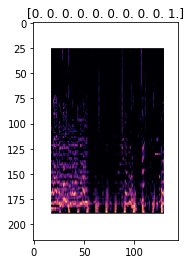

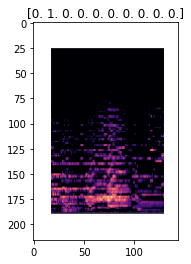

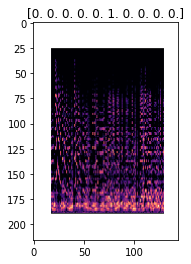

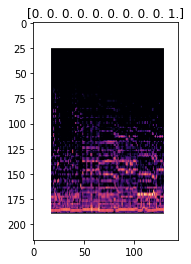

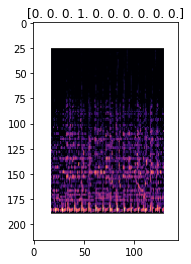

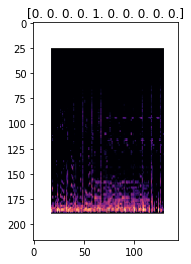

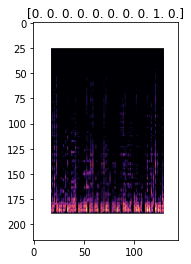

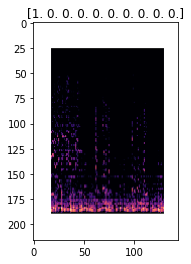

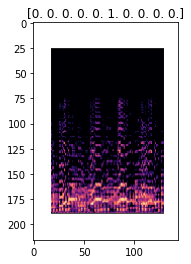

In [ ]:
# Funkcja .next() zwraca koleny batch zdjęć. Możemy jej użyć do wizualizacji zdjęć oraz odczytania ich etykiet (label).
x,y= train_dataset.next()
for i in range(0,10):
    image = x[i]
    plt.imshow(image)
    plt.title(y[i])
    plt.show()

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
vgg_conv=VGG16(weights='imagenet', include_top=False,input_shape=(int(train_dataset.target_size[0]), int(train_dataset.target_size[1]), 3))
# parametr include_top = False odpowiada za to, że użyte zostaną jedynie warstwy konwolucyjne oraz maxpool z wagami 

In [ ]:
def create_transfer_learning_model():
  return tf.keras.Sequential(
      [vgg_conv,
       tf.keras.layers.Flatten(),
       # tf.keras.layers.Dense(256, activation='relu'),
       tf.keras.layers.Dense(128, activation='relu'),
       tf.keras.layers.Dense(len(train_dataset.class_indices.values()), activation='softmax')])

In [ ]:
transfer_learning_model = create_transfer_learning_model()

transfer_learning_model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC(multi_label=False)])
transfer_learning_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 128)               1572992   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 16,288,970
Trainable params: 16,288,970
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_transfer_learning_model = transfer_learning_model.fit_generator(
    train_dataset, epochs=30, verbose=1,
    validation_data=val_dataset,
    callbacks=[early_stop])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


80/80 [==============================] - 55s 604ms/step - loss: 2.5633 - categorical_accuracy: 0.0812 - auc: 0.4851 - val_loss: 2.3027 - val_categorical_accuracy: 0.1005 - val_auc: 0.4986
Epoch 2/30
80/80 [==============================] - 48s 603ms/step - loss: 2.3033 - categorical_accuracy: 0.0862 - auc: 0.4861 - val_loss: 2.3026 - val_categorical_accuracy: 0.1005 - val_auc: 0.5006
Epoch 3/30
80/80 [==============================] - 44s 548ms/step - loss: 2.3031 - categorical_accuracy: 0.0900 - auc: 0.4889 - val_loss: 2.3026 - val_categorical_accuracy: 0.1005 - val_auc: 0.4980
Epoch 4/30
80/80 [==============================] - 46s 571ms/step - loss: 2.3031 - categorical_accuracy: 0.0763 - auc: 0.4868 - val_loss: 2.3026 - val_categorical_accuracy: 0.1005 - val_auc: 0.5006
Epoch 5/30
80/80 [==============================] - 44s 550ms/step - loss: 2.3033 - categorical_accuracy: 0.0938 - auc: 0.4868 - val_loss: 2.3026 - val_categorical_accuracy: 0.1005 - val_auc: 0.5008
Epoch 6/30
80/80

<Figure size 432x288 with 0 Axes>

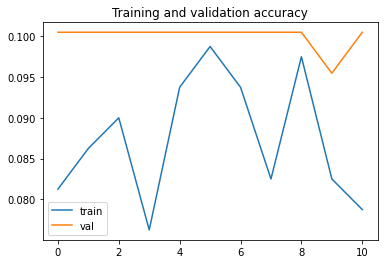

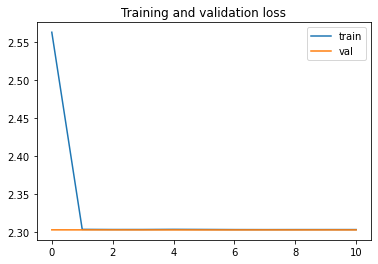

<Figure size 432x288 with 0 Axes>

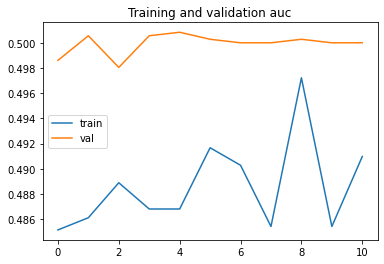

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history_transfer_learning_model.history['categorical_accuracy']
val_acc = history_transfer_learning_model.history['val_categorical_accuracy']

loss = history_transfer_learning_model.history['loss']
val_loss = history_transfer_learning_model.history['val_loss']

auc = history_transfer_learning_model.history['auc']
val_auc = history_transfer_learning_model.history['val_auc']

epochs = range(len(acc))
plt.figure()
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.legend(['train','val'])
plt.title('Training and validation accuracy')

plt.figure()
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.legend(['train','val'])
plt.title('Training and validation loss')
plt.figure()

plt.figure()
plt.plot(epochs, auc)
plt.plot(epochs, val_auc)
plt.legend(['train','val'])
plt.title('Training and validation auc')
plt.figure()

In [ ]:
def create_music_model():
  return tf.keras.Sequential(
      [tf.keras.layers.InputLayer(input_shape = (train_dataset.target_size[0], train_dataset.target_size[1], 3)), # Pierwsza warstwa wejściowa. Etap może zostać pominięty, jeżeli w kolejnej warstwie zostanie podany input_shape
       tf.keras.layers.Conv2D(64, 5,padding = 'same', activation='relu'),
       tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
       tf.keras.layers.Conv2D(32, 2,padding = 'same', activation='relu'),
       tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
       tf.keras.layers.Conv2D(16, 2,padding = 'same', activation='relu'),
       tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
       tf.keras.layers.Dense(len(train_dataset.class_indices.values()), activation='softmax')])

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# Zmienny lr - użyj klasy LearningRateSchedule
# Przykład:

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=100,
    decay_rate=0.8)


In [ ]:
music_model = create_music_model()

music_model.compile(optimizer=Adam(
    learning_rate = lr_schedule
),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC(multi_label=False)])
music_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 216, 144, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 108, 72, 64)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 72, 32)       8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 54, 36, 16)        2064      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 27, 18, 16)       0

In [ ]:
history_music_model = music_model.fit_generator(
    train_dataset,
     epochs=100,
     verbose=1,
     validation_data=val_dataset,
     callbacks=[early_stop])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


80/80 [==============================] - 10s 108ms/step - loss: 3.1094 - categorical_accuracy: 0.0825 - auc: 0.4789 - val_loss: 2.3543 - val_categorical_accuracy: 0.1005 - val_auc: 0.5308
Epoch 2/100
80/80 [==============================] - 8s 100ms/step - loss: 2.3119 - categorical_accuracy: 0.1112 - auc: 0.5510 - val_loss: 2.2561 - val_categorical_accuracy: 0.1206 - val_auc: 0.6135
Epoch 3/100
80/80 [==============================] - 8s 99ms/step - loss: 2.1845 - categorical_accuracy: 0.2138 - auc: 0.6616 - val_loss: 2.0656 - val_categorical_accuracy: 0.2613 - val_auc: 0.7229
Epoch 4/100
80/80 [==============================] - 8s 98ms/step - loss: 1.9908 - categorical_accuracy: 0.3137 - auc: 0.7553 - val_loss: 1.9774 - val_categorical_accuracy: 0.3367 - val_auc: 0.7655
Epoch 5/100
80/80 [==============================] - 8s 98ms/step - loss: 1.6836 - categorical_accuracy: 0.4400 - auc: 0.8511 - val_loss: 1.7674 - val_categorical_accuracy: 0.4271 - val_auc: 0.8293
Epoch 6/100
80/80 [

<Figure size 432x288 with 0 Axes>

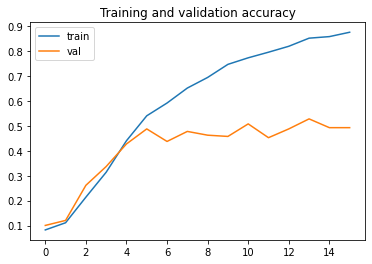

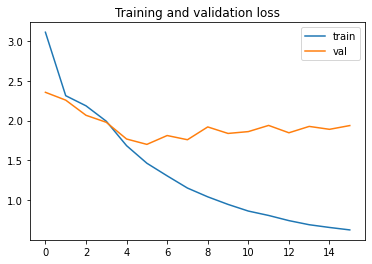

<Figure size 432x288 with 0 Axes>

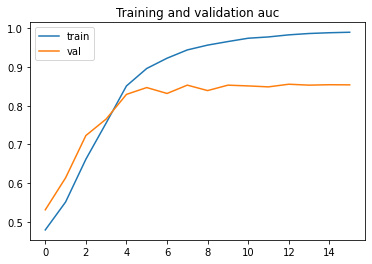

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history_music_model.history['categorical_accuracy']
val_acc = history_music_model.history['val_categorical_accuracy']

loss = history_music_model.history['loss']
val_loss = history_music_model.history['val_loss']

auc = history_music_model.history['auc']
val_auc = history_music_model.history['val_auc']

epochs = range(len(acc))
plt.figure()
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.legend(['train','val'])
plt.title('Training and validation accuracy')

plt.figure()
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.legend(['train','val'])
plt.title('Training and validation loss')
plt.figure()

plt.figure()
plt.plot(epochs, auc)
plt.plot(epochs, val_auc)
plt.legend(['train','val'])
plt.title('Training and validation auc')
plt.figure()

In [ ]:
val_dataset.shuffle=False

In [ ]:
# Predykcje przy użyciu modelu
# Należy ustawić parametr .shuffle na False, aby generator nie pokazywał losowo zdjęć do predykcji. Ułatwia to walidację wyników.
val_dataset.shuffle=False
y_pred = music_model.predict_generator(val_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


In [ ]:
# Predykcje klas. np.argmax zwraca indeks kolumny z najwyższą wartością.
y_pred_classes = np.argmax(y_pred,axis = 1)
y_pred_classes

array([8, 8, 2, 0, 1, 7, 4, 4, 2, 4, 1, 0, 5, 5, 5, 4, 8, 8, 5, 5, 1, 1,
       1, 1, 1, 1, 5, 1, 5, 5, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 6, 6, 8, 3,
       9, 6, 9, 9, 9, 6, 5, 8, 2, 2, 7, 9, 2, 2, 9, 5, 3, 6, 3, 6, 7, 6,
       6, 3, 6, 9, 3, 9, 3, 7, 6, 9, 3, 3, 7, 3, 3, 4, 4, 7, 8, 3, 7, 4,
       7, 4, 9, 4, 3, 9, 6, 8, 4, 8, 4, 7, 3, 5, 1, 5, 5, 5, 5, 5, 5, 5,
       0, 5, 5, 5, 1, 2, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 8, 9, 9, 7, 5, 7, 7, 9, 1, 9, 8, 9,
       7, 7, 9, 7, 7, 3, 5, 8, 8, 8, 8, 8, 8, 8, 4, 0, 8, 4, 8, 8, 4, 3,
       8, 8, 8, 3, 5, 4, 8, 7, 9, 2, 2, 9, 5, 3, 0, 4, 4, 4, 4, 6, 6, 9,
       9])

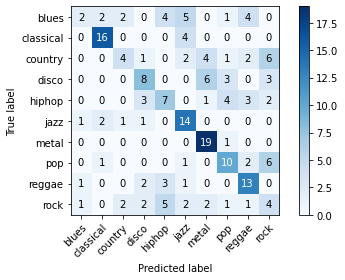

In [ ]:
# Wykres macierzy błędu
target_names = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
plot_confusion_matrix(val_dataset.classes, y_pred_classes,classes=target_names)

In [ ]:
# Moduł sklearn.metrics pozwala na automatyczne obliczenie bardziej skomplikowanych metryk.
print('Confusion Matrix')
print(metrics.confusion_matrix(val_dataset.classes, y_pred_classes))
print('Classification Report')
print(metrics.classification_report(val_dataset.classes, y_pred_classes, target_names=target_names))
print('Accuracy = '+ str(metrics.accuracy_score(val_dataset.classes,y_pred_classes)))

Confusion Matrix
[[ 2  2  2  0  4  5  0  1  4  0]
 [ 0 16  0  0  0  4  0  0  0  0]
 [ 0  0  4  1  0  2  4  1  2  6]
 [ 0  0  0  8  0  0  6  3  0  3]
 [ 0  0  0  3  7  0  1  4  3  2]
 [ 1  2  1  1  0 14  0  0  0  0]
 [ 0  0  0  0  0  0 19  1  0  0]
 [ 0  1  0  0  0  1  0 10  2  6]
 [ 1  0  0  2  3  1  0  0 13  0]
 [ 1  0  2  2  5  2  2  1  1  4]]
Classification Report
              precision    recall  f1-score   support

       blues       0.40      0.10      0.16        20
   classical       0.76      0.80      0.78        20
     country       0.44      0.20      0.28        20
       disco       0.47      0.40      0.43        20
      hiphop       0.37      0.35      0.36        20
        jazz       0.48      0.74      0.58        19
       metal       0.59      0.95      0.73        20
         pop       0.48      0.50      0.49        20
      reggae       0.52      0.65      0.58        20
        rock       0.19      0.20      0.20        20

    accuracy                      